# Using LCCDE on UNSW-NB15 with different models


## Importing required libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 102 kB/s 


In [4]:
!pip install river

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 6.9 MB/s 


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import catboost as cbt
#from catboost import CatBoostClassifier as cbt
import xgboost as xgb
import time
from river import stream
from statistics import mode

## Read the sampled UNSW-NB15 dataset
The UNSW-NB15 dataset is publicly available at: https://cloudstor.aarnet.edu.au/plus/index.php/s/2DhnLGDdEECo4ys?path=%2FUNSW-NB15%20-%20CSV%20Files%2Fa%20part%20of%20training%20and%20testing%20set

We utilized the training and testing subsets of UNSW-NB15 as provided by Moustafa et al. (Moustafa, 2017). They selected 175,341 records to form the training subset and 82,332 records for the testing subset among the original 2,218,761 records.

The dataset has been uploaded to drive and can be downloaded by the code given below.

In [6]:
# Downloading Train set from Drive
!gdown 1E0Wxb4BujGVSq70qnxi-_VmpI6TLdG89

Downloading...
From: https://drive.google.com/uc?id=1E0Wxb4BujGVSq70qnxi-_VmpI6TLdG89
To: /content/UNSW_NB15_trainset.csv
100% 32.3M/32.3M [00:00<00:00, 37.7MB/s]


In [7]:
# Downloading Test set form Drive
!gdown 1VVPlpH3KR0Znwp4vYiW0uRBZ2B5Smc2o

Downloading...
From: https://drive.google.com/uc?id=1VVPlpH3KR0Znwp4vYiW0uRBZ2B5Smc2o
To: /content/UNSW_NB15_testset.csv
100% 15.4M/15.4M [00:00<00:00, 48.0MB/s]


In [9]:
df_train = pd.read_csv("/content/UNSW_NB15_trainset.csv")

In [10]:
df_train

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
175337,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
175338,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
175339,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [11]:
df_test = pd.read_csv("/content/UNSW_NB15_testset.csv")

In [12]:
df_test

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


Let us take a look at the different type of attacks present in the dataset.

In [13]:
df_train.attack_cat.value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

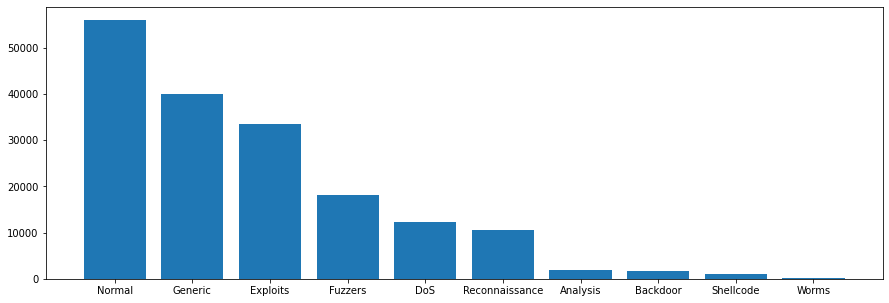

In [14]:
plt.figure(figsize=(15, 5))
plt.bar(df_train.attack_cat.value_counts().index, df_train.attack_cat.value_counts())
plt.show()

We can observe that the number of attacks of type: Exploits, DoS, Worms and Generic are very low

##Preprocessing

First, we combine the train and test cases, so the categorical values can be encoded into numerical values

In [ ]:
df = pd.concat([df_train, df_test])

In [ ]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  sin

We can observe that 4 columns: proto, service, state, attack_cat are categorical variables.

###Encoding proto, service, state and attack_cat

Before encoding, the data in proto contains values such as tcp, upd ...

In [ ]:
df.attack_cat.value_counts()

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

We encode the following columns using LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

categ = ['proto','service','state', 'attack_cat']

# Encode Categorical Columns
le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

In [ ]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,113,0,4,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,6,0
1,2,0.649902,113,0,4,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,6,0
2,3,1.623129,113,0,4,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,6,0
3,4,1.681642,113,3,4,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,6,0
4,5,0.449454,113,0,4,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,119,0,5,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,6,0
82328,82329,1.106101,113,0,4,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,6,0
82329,82330,0.000000,6,0,5,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,6,0
82330,82331,0.000000,6,0,5,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,6,0


After encoding, the categorical values: tcp, udp... has been converted to numerical values.

In [ ]:
df.attack_cat.value_counts()

6    93000
5    58871
3    44525
4    24246
2    16353
7    13987
0     2677
1     2329
8     1511
9      174
Name: attack_cat, dtype: int64

### Split train set and test set

Now that all columns are in numerical format, the dataset is split back again.

Additionally, the X values will contain all columns expect id, label and attack_cat. The value our model will predict is attack_cat, which is taken as y.

In [ ]:
X_train = df[0:175341].drop(['id', 'label',  'attack_cat'], axis=1)
y_train = df[0:175341]['attack_cat']

X_test = df[175341:257673].drop(['id', 'label', 'attack_cat'], axis=1)
y_test = df[175341:257673]['attack_cat']

In [ ]:
X_train

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,1,1,0,0,0,1,1,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,1,1,2,0,0,0,1,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,2,1,1,3,0,0,0,2,6,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,2,1,1,3,1,1,0,2,1,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,2,2,1,40,0,0,0,2,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,119,2,5,2,0,114,0,111111.107200,254,...,24,24,13,24,0,0,0,24,24,0
175337,0.505762,113,0,4,10,8,620,354,33.612649,254,...,1,1,1,2,0,0,0,1,1,0
175338,0.000009,119,2,5,2,0,114,0,111111.107200,254,...,3,3,3,13,0,0,0,3,12,0
175339,0.000009,119,2,5,2,0,114,0,111111.107200,254,...,30,30,14,30,0,0,0,30,30,0


In [ ]:
y_train

0         6
1         6
2         6
3         6
4         6
         ..
175336    5
175337    8
175338    5
175339    5
175340    5
Name: attack_cat, Length: 175341, dtype: int64

In [ ]:
X_test

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.000011,119,0,5,2,0,496,0,90909.090200,254,...,1,1,1,2,0,0,0,1,2,0
1,0.000008,119,0,5,2,0,1762,0,125000.000300,254,...,1,1,1,2,0,0,0,1,2,0
2,0.000005,119,0,5,2,0,1068,0,200000.005100,254,...,1,1,1,3,0,0,0,1,3,0
3,0.000006,119,0,5,2,0,900,0,166666.660800,254,...,2,2,1,3,0,0,0,2,3,0
4,0.000010,119,0,5,2,0,2126,0,100000.002500,254,...,2,2,1,3,0,0,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,119,0,5,2,0,104,0,200000.005100,254,...,2,1,1,2,0,0,0,2,1,0
82328,1.106101,113,0,4,20,8,18062,354,24.410067,254,...,2,1,1,1,0,0,0,3,2,0
82329,0.000000,6,0,5,1,0,46,0,0.000000,0,...,1,1,1,1,0,0,0,1,1,1
82330,0.000000,6,0,5,1,0,46,0,0.000000,0,...,1,1,1,1,0,0,0,1,1,1


In [ ]:
y_test

0        6
1        6
2        6
3        6
4        6
        ..
82327    6
82328    6
82329    6
82330    6
82331    6
Name: attack_cat, Length: 82332, dtype: int64

### SMOTE to solve class-imbalance

As we observed perviously, the number of attacks of the classes: Exploits, DoS, Worms and Generic are very low.

Here, we use SMOTE method, an oversampling technique to increase the number of samples in the 4 minority classes in the training set.

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy={0:3000,1:3000, 8:3000, 9:3000}, random_state = 1)
# Classes 0, 1, 8, 9 are oversampled to each 3000 samples

In [ ]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
y_train_smote.value_counts()

6    56000
5    40000
3    33393
4    18184
2    12264
7    10491
1     3000
0     3000
8     3000
9     3000
Name: attack_cat, dtype: int64

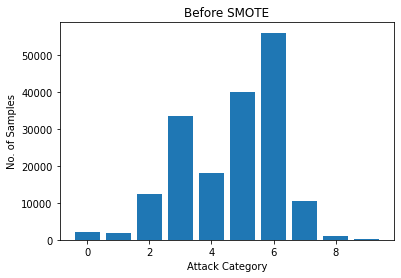

In [ ]:
plt.bar(y_train.value_counts().index, y_train.value_counts())
plt.title("Before SMOTE")
plt.xlabel("Attack Category")
plt.ylabel("No. of Samples")
plt.show()

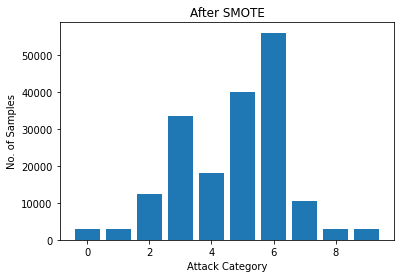

In [ ]:
plt.title("After SMOTE")
plt.xlabel("Attack Category")
plt.ylabel("No. of Samples")
plt.bar(y_train_smote.value_counts().index, y_train_smote.value_counts())
plt.show()

## Base Machine Learning (ML) model training
### Training base learners: LightGBM, XGBoost, CatBoost

###LightBGM on NB15

              precision    recall  f1-score   support

           0       0.05      0.07      0.05       677
           1       0.03      0.08      0.05       583
           2       0.43      0.08      0.13      4089
           3       0.59      0.84      0.69     11132
           4       0.31      0.61      0.41      6062
           5       0.99      0.97      0.98     18871
           6       0.97      0.75      0.85     37000
           7       0.90      0.81      0.85      3496
           8       0.29      0.76      0.42       378
           9       0.06      0.41      0.10        44

    accuracy                           0.76     82332
   macro avg       0.46      0.54      0.45     82332
weighted avg       0.83      0.76      0.78     82332

Accuracy of LightGBM: 0.7615022105621143
Precision of LightGBM: 0.8283591141328117
Recall of LightGBM: 0.7615022105621143
Average F1 of LightGBM: 0.7754872938377338
F1 of LightGBM for each type of attack: [0.05466429 0.04573606 0.13228281 0.

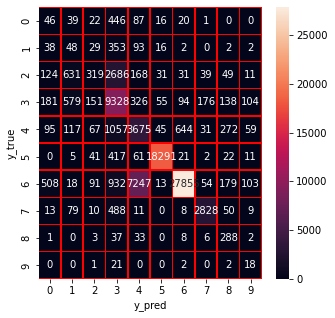

CPU times: user 1min 42s, sys: 477 ms, total: 1min 43s
Wall time: 1min 14s


In [ ]:
%%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)

#Printing the results
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the results for LCCDE
lg_f1_avg = f1_score(y_test, y_pred, average='weighted')
model_before = lg
lg_f1 = f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

###LightBGM on NB15-SMOTE

              precision    recall  f1-score   support

           0       0.09      0.34      0.14       677
           1       0.05      0.14      0.07       583
           2       0.60      0.08      0.14      4089
           3       0.63      0.82      0.71     11132
           4       0.32      0.59      0.42      6062
           5       1.00      0.97      0.98     18871
           6       0.97      0.76      0.85     37000
           7       0.94      0.81      0.87      3496
           8       0.24      0.85      0.38       378
           9       0.45      0.68      0.55        44

    accuracy                           0.77     82332
   macro avg       0.53      0.60      0.51     82332
weighted avg       0.85      0.77      0.78     82332

Accuracy of LightGBM: 0.7654496429091969
Precision of LightGBM: 0.84621739751016
Recall of LightGBM: 0.7654496429091969
Average F1 of LightGBM: 0.7835925897191821
F1 of LightGBM for each type of attack: [0.14018978 0.07020476 0.13688542 0.71

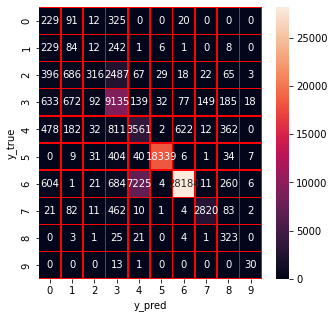

CPU times: user 1min 34s, sys: 486 ms, total: 1min 35s
Wall time: 50.2 s


In [ ]:
%%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train_smote, y_train_smote)

y_pred = lg.predict(X_test)

#Printing the results
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the results for LCCDE
#Storing whichever model has better weighted f1 in NB15 vs NB15-SMOTE
if(f1_score(y_test, y_pred, average='weighted') > lg_f1_avg):
  lg_f1=f1_score(y_test, y_pred, average=None)
else:
  lg = model_before

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

###XGboost on NB15

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.63      0.04      0.07       583
           2       0.31      0.02      0.04      4089
           3       0.55      0.93      0.69     11132
           4       0.29      0.55      0.38      6062
           5       1.00      0.96      0.98     18871
           6       0.94      0.74      0.83     37000
           7       0.87      0.81      0.84      3496
           8       0.43      0.56      0.49       378
           9       0.71      0.39      0.50        44

    accuracy                           0.76     82332
   macro avg       0.57      0.50      0.48     82332
weighted avg       0.81      0.76      0.76     82332

Accuracy of XGBoost: 0.7590122916970315
Precision of XGBoost: 0.8073592288768312
Recall of XGBoost: 0.7590122916970315
Average F1 of XGBoost: 0.7601791770351535
F1 of XGBoost for each type of attack: [0.         0.07119741 0.04066712 0.69126

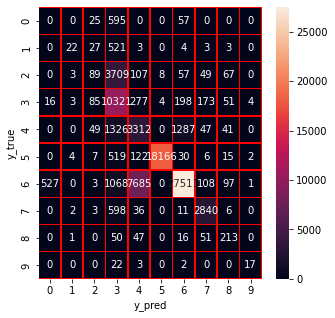

CPU times: user 4min 16s, sys: 449 ms, total: 4min 16s
Wall time: 4min 18s


In [ ]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

#Printing Accuracy
y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the F1 score
xg_f1_avg = f1_score(y_test, y_pred, average='weighted')
xg_f1=f1_score(y_test, y_pred, average=None)
model_before = xg

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

###XGBoost on NB15-SMOTE

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.46      0.04      0.07       583
           2       0.32      0.02      0.04      4089
           3       0.55      0.91      0.69     11132
           4       0.29      0.57      0.38      6062
           5       1.00      0.96      0.98     18871
           6       0.95      0.73      0.83     37000
           7       0.92      0.81      0.86      3496
           8       0.21      0.78      0.34       378
           9       0.39      0.75      0.51        44

    accuracy                           0.76     82332
   macro avg       0.51      0.56      0.47     82332
weighted avg       0.81      0.76      0.76     82332

Accuracy of XGBoost: 0.755101297186999
Precision of XGBoost: 0.8134615817640773
Recall of XGBoost: 0.755101297186999
Average F1 of XGBoost: 0.7598737139858301
F1 of XGBoost for each type of attack: [0.         0.06973059 0.04458599 0.6888670

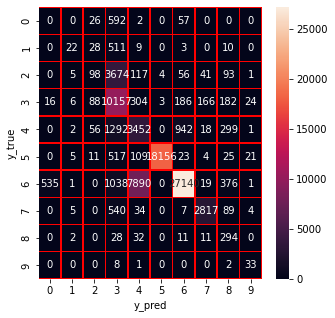

CPU times: user 4min 26s, sys: 559 ms, total: 4min 27s
Wall time: 4min 26s


In [ ]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_smote_x = X_train_smote.values
X_test_x = X_test.values

xg.fit(X_train_smote_x, y_train_smote)

#Printing Accuracy
y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the F1 score
if(f1_score(y_test, y_pred, average='weighted') > xg_f1_avg):
  xg_f1=f1_score(y_test, y_pred, average=None)
else:
  xg = model_before

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

###CatBoost on NB15

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.05      0.11      0.06       583
           2       0.64      0.07      0.12      4089
           3       0.58      0.89      0.71     11132
           4       0.31      0.58      0.41      6062
           5       1.00      0.97      0.98     18871
           6       0.96      0.76      0.85     37000
           7       0.92      0.81      0.86      3496
           8       0.36      0.74      0.49       378
           9       0.75      0.14      0.23        44

    accuracy                           0.77     82332
   macro avg       0.56      0.51      0.47     82332
weighted avg       0.84      0.77      0.78     82332

Accuracy of CatBoost: 0.7709031725210125
Precision of CatBoost: 0.8361303966014327
Recall of CatBoost: 0.7709031725210125
Average F1 of CatBoost: 0.7791059279635132
F1 of CatBoost for each type of attack: [0.00275672 0.06431535 0.12488967 0.

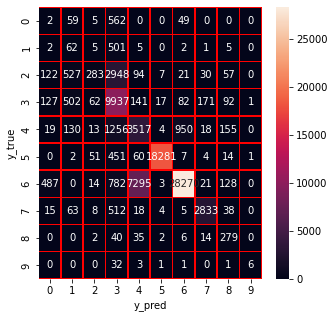

CPU times: user 31min 51s, sys: 4.96 s, total: 31min 56s
Wall time: 17min 4s


In [ ]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)

#Printing Accuracy
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the F1 score
cb_f1=f1_score(y_test, y_pred, average=None)
cb_f1_avg = f1_score(y_test, y_pred, average='weighted')
model_before = cb

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

###CatBoost on NB15-SMOTE

              precision    recall  f1-score   support

           0       0.00      0.01      0.00       677
           1       0.03      0.07      0.04       583
           2       0.64      0.06      0.11      4089
           3       0.59      0.87      0.70     11132
           4       0.31      0.55      0.40      6062
           5       1.00      0.97      0.98     18871
           6       0.96      0.76      0.85     37000
           7       0.92      0.80      0.86      3496
           8       0.26      0.87      0.40       378
           9       0.24      0.59      0.34        44

    accuracy                           0.76     82332
   macro avg       0.50      0.55      0.47     82332
weighted avg       0.83      0.76      0.77     82332

Accuracy of CatBoost: 0.7634577078171306
Precision of CatBoost: 0.8347149481845989
Recall of CatBoost: 0.7634577078171306
Average F1 of CatBoost: 0.774551251003967
F1 of CatBoost for each type of attack: [0.00431499 0.03889159 0.10715086 0.7

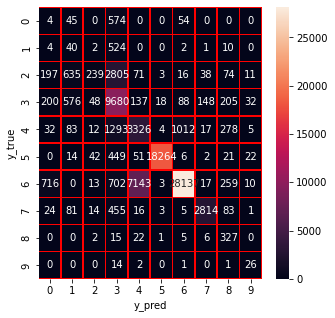

CPU times: user 33min 6s, sys: 5.35 s, total: 33min 11s
Wall time: 17min 44s


In [ ]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()
cb.fit(X_train_smote, y_train_smote)
y_pred = cb.predict(X_test)

#Printing Accuracy
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the F1 score
if(f1_score(y_test, y_pred, average='weighted') > cb_f1_avg):
  cb_f1=f1_score(y_test, y_pred, average=None)
else:
  cb = model_before

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

###Random Forest on NB15

Tuning hyperparameters:
1. max_depth

In [ ]:
from sklearn.ensemble import RandomForestClassifier

for k in range(1, 50):
  rf = RandomForestClassifier(n_estimators=50, max_depth=k, random_state=0)
  rf.fit(X_train, y_train)
  y_pred =rf.predict(X_test)
  print(str(k) + " : "+ str(f1_score(y_test, y_pred, average='weighted')))




1 : 0.4726590842991957
2 : 0.5492299270703968
3 : 0.5771115925491043
4 : 0.6863482709534644
5 : 0.6956339323321368
6 : 0.7186686934425257
7 : 0.7196510686801131
8 : 0.7330367115806159
9 : 0.7451493619249487
10 : 0.7560339430197376
11 : 0.7623205674402753
12 : 0.7658358556251978
13 : 0.771392059047741
14 : 0.7703225445996391
15 : 0.7760235440446398
16 : 0.7776223972474436
17 : 0.7761944838948209
18 : 0.7765719816626745
19 : 0.7783864862498413
20 : 0.7768990827973477
21 : 0.778583208165759
22 : 0.7769360974915572
23 : 0.7774455027361347
24 : 0.7782759213191414
25 : 0.7780464495154703
26 : 0.7780482120745478
27 : 0.77850494713395
28 : 0.7785603994100344
29 : 0.7783212878238804
30 : 0.7774673723099672
31 : 0.7775724336454674
32 : 0.7771266540625167
33 : 0.7777028952900334
34 : 0.7780827151771559
35 : 0.777530709036483
36 : 0.7770536353977778
37 : 0.7766364940127447
38 : 0.7759409823885437
39 : 0.7771093111950015
40 : 0.7776900927749102
41 : 0.7776815570271414
42 : 0.7769374478852732
43 : 0

Choosing max depth 19 with f1 score of 0.7783864862498413

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       677
           1       0.03      0.07      0.05       583
           2       0.66      0.09      0.16      4089
           3       0.59      0.86      0.70     11132
           4       0.30      0.60      0.40      6062
           5       1.00      0.97      0.98     18871
           6       0.97      0.76      0.85     37000
           7       0.93      0.80      0.86      3496
           8       0.36      0.71      0.48       378
           9       0.75      0.14      0.23        44

    accuracy                           0.77     82332
   macro avg       0.56      0.50      0.47     82332
weighted avg       0.84      0.77      0.78     82332

Accuracy of RandomForest: 0.7654617888548803
Precision of RandomForest: 0.8400190260544648
Recall of RandomForest: 0.7654617888548803
Average F1 of RandomForest: 0.7783864862498413
F1 of RandomForest for each type of attack: [0.00932945 0.04

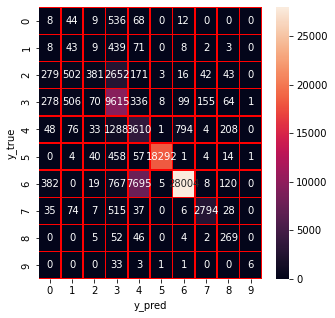

CPU times: user 18.6 s, sys: 166 ms, total: 18.8 s
Wall time: 18.6 s


In [ ]:
%%time
# Train the RandomForest algorithm
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=19, random_state=0)
rf.fit(X_train, y_train)
y_pred =rf.predict(X_test)

#Printing Accuracy
print(classification_report(y_test,y_pred))
print("Accuracy of RandomForest: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of RandomForest: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of RandomForest: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of RandomForest: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of RandomForest for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the F1 score
rf_f1=f1_score(y_test, y_pred, average=None)
rf_f1_avg = f1_score(y_test, y_pred, average='weighted')
model_before = rf

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

###Random Forest on NB15-SMOTE

              precision    recall  f1-score   support

           0       0.04      0.07      0.05       677
           1       0.04      0.14      0.06       583
           2       0.77      0.09      0.16      4089
           3       0.61      0.82      0.70     11132
           4       0.29      0.59      0.39      6062
           5       1.00      0.97      0.98     18871
           6       0.97      0.75      0.84     37000
           7       0.94      0.80      0.87      3496
           8       0.25      0.82      0.38       378
           9       0.37      0.57      0.45        44

    accuracy                           0.76     82332
   macro avg       0.53      0.56      0.49     82332
weighted avg       0.85      0.76      0.78     82332

Accuracy of RandomForest: 0.7566802701258319
Precision of RandomForest: 0.8484786003481959
Recall of RandomForest: 0.7566802701258319
Average F1 of RandomForest: 0.775662750839826
F1 of RandomForest for each type of attack: [0.0496771  0.061

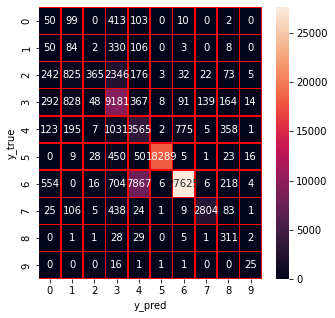

CPU times: user 21.1 s, sys: 271 ms, total: 21.4 s
Wall time: 21.3 s


In [ ]:
%%time
# Train the RandomForest algorithm
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, max_depth=19, random_state=0)
rf.fit(X_train_smote, y_train_smote)
y_pred = rf.predict(X_test)

#Printing Accuracy
print(classification_report(y_test,y_pred))
print("Accuracy of RandomForest: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of RandomForest: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of RandomForest: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of RandomForest: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of RandomForest for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the F1 score
if(f1_score(y_test, y_pred, average='weighted') > rf_f1_avg):
  rf_f1=f1_score(y_test, y_pred, average=None)
else:
  rf = model_before

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

###AdaBoost on NB15

              precision    recall  f1-score   support

           0       0.07      0.71      0.12       677
           1       0.01      0.05      0.01       583
           2       0.23      0.01      0.02      4089
           3       0.35      0.33      0.34     11132
           4       0.20      0.34      0.25      6062
           5       0.97      0.58      0.72     18871
           6       0.92      0.44      0.59     37000
           7       0.17      0.73      0.28      3496
           8       0.16      0.29      0.21       378
           9       0.01      0.64      0.01        44

    accuracy                           0.44     82332
   macro avg       0.31      0.41      0.26     82332
weighted avg       0.72      0.44      0.51     82332

Accuracy of AdaBoost: 0.43674391488121267
Precision of AdaBoost: 0.7179142619279606
Recall of AdaBoost: 0.43674391488121267
Average F1 of AdaBoost: 0.5111053023275782
F1 of AdaBoost for each type of attack: [0.11951401 0.00987733 0.02412433 

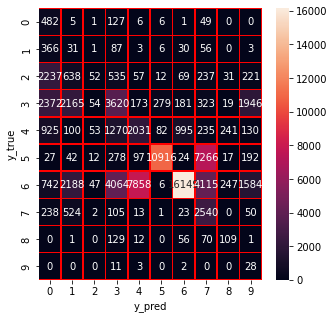

CPU times: user 51.9 s, sys: 776 ms, total: 52.6 s
Wall time: 52.4 s


In [ ]:
%%time
# Train the AdaBoost algorithm
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(n_estimators=100, random_state=0)
ab.fit(X_train, y_train)
y_pred = ab.predict(X_test)

#Printing Accuracy
print(classification_report(y_test,y_pred))
print("Accuracy of AdaBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of AdaBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of AdaBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of AdaBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of AdaBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the F1 score
ab_f1=f1_score(y_test, y_pred, average=None)
ab_f1_avg = f1_score(y_test, y_pred, average='weighted')
model_before = ab

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

###AdaBoost on NB15-SMOTE

              precision    recall  f1-score   support

           0       0.04      0.74      0.08       677
           1       0.02      0.04      0.03       583
           2       0.37      0.00      0.01      4089
           3       0.45      0.27      0.33     11132
           4       0.18      0.18      0.18      6062
           5       1.00      0.38      0.55     18871
           6       0.94      0.65      0.77     37000
           7       0.13      0.37      0.19      3496
           8       0.07      0.72      0.13       378
           9       0.00      0.80      0.01        44

    accuracy                           0.45     82332
   macro avg       0.32      0.41      0.23     82332
weighted avg       0.75      0.45      0.54     82332

Accuracy of AdaBoost: 0.453274546956226
Precision of AdaBoost: 0.7492998201498546
Recall of AdaBoost: 0.453274546956226
Average F1 of AdaBoost: 0.5384332235555769
F1 of AdaBoost for each type of attack: [0.07521857 0.02801462 0.00869986 0.33

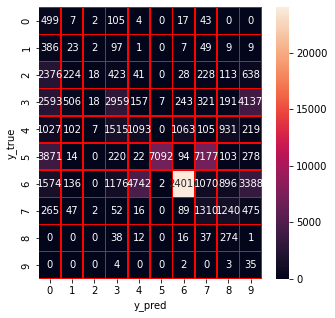

CPU times: user 55 s, sys: 986 ms, total: 56 s
Wall time: 55.8 s


In [ ]:
%%time
# Train the AdaBoost algorithm
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(n_estimators=100, random_state=0)
ab.fit(X_train_smote, y_train_smote)
y_pred = ab.predict(X_test)

#Printing Accuracy
print(classification_report(y_test,y_pred))
print("Accuracy of AdaBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of AdaBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of AdaBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of AdaBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of AdaBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

#Storing the F1 score
if(f1_score(y_test, y_pred, average='weighted') > ab_f1_avg):
  ab_f1=f1_score(y_test, y_pred, average=None)
else:
  ab = model_before
# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Ensemble model: Leader Class and Confidence Decision Ensemble (LCCDE)

LCCDE aims to achieve optimal model performance by identifying the best-performing base ML model with the highest prediction confidence for each class. 

### Find the best-performing (leading) model for each type of attack among the five ML models

In [ ]:
# Leading model list for each class
model=[]
for i in range(len(lg_f1)):
    if max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], ab_f1[i]) == lg_f1[i]:
        model.append(lg)
    elif max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], ab_f1[i]) == xg_f1[i]:
        model.append(xg)
    elif max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], ab_f1[i]) == cb_f1[i]:
        model.append(cb)
    elif max(lg_f1[i], xg_f1[i], cb_f1[i], rf_f1[i], ab_f1[i]) == rf_f1[i]:
        model.append(rf)
    else:
        model.append(ab)

In [ ]:
model

[LGBMClassifier(),
 XGBClassifier(objective='multi:softprob'),
 RandomForestClassifier(max_depth=19, n_estimators=50, random_state=0),
 LGBMClassifier(),
 LGBMClassifier(),
 RandomForestClassifier(max_depth=19, n_estimators=50, random_state=0),
 LGBMClassifier(),
 LGBMClassifier(),
 XGBClassifier(objective='multi:softprob'),
 LGBMClassifier()]

**Leading Model for Each Type of Attack:**  



*   0 Analysis : LGBM
*   1 Backdoor : XGB
*   2 DoS : Random Forest
*   3 Exploits : LGBM
*   4 Fuzzers : LGBM
*   5 Generic : Random Forest
*   6 Normal : LGBM
*   7 Reconnaissance : LGBM
*   8 Shellcode : XGB
*   9 Worms : LGBM





6 Normal            93000
5 Generic           58871
3 Exploits          44525
4 Fuzzers           24246
2 DoS               16353
7 Reconnaissance    13987
0 Analysis           2677
1 Backdoor           2329
8 Shellcode          1511
9 Worms               174





The three models LGBM, XGB, and Random Forest are chosen and given to LCCDE

## LCCDE Prediction

In [ ]:
def LCCDE(X_test, y_test, m1, m2, m3):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred1 = m1.predict(xi2.reshape(1, -1))      # model 1 (LightGBM) makes a prediction on text sample xi
        y_pred1 = int(y_pred1[0])
        y_pred2 = m2.predict(xi2.reshape(1, -1))      # model 2 (XGBoost) makes a prediction on text sample xi
        y_pred2 = int(y_pred2[0])
        y_pred3 = m3.predict(xi2.reshape(1, -1))      # model 3 (Catboost) makes a prediction on text sample xi
        y_pred3 = int(y_pred3[0])

        p1 = m1.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 1 
        p2 = m2.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 2  
        p3 = m3.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 3  

        # Find the highest prediction probability among all classes for each ML model
        y_pred_p1 = np.max(p1)
        y_pred_p2 = np.max(p2)
        y_pred_p3 = np.max(p3)

        if y_pred1 == y_pred2 == y_pred3: # If the predicted classes of all the three models are the same
            y_pred = y_pred1 # Use this predicted class as the final predicted class

        elif y_pred1 != y_pred2 != y_pred3: # If the predicted classes of all the three models are different
            # For each prediction model, check if the predicted class’s original ML model is the same as its leader model
            if model[y_pred1]==m1: # If they are the same and the leading model is model 1 
                l.append(m1)
                pred_l.append(y_pred1) # Save the predicted class
                pro_l.append(y_pred_p1) # Save the confidence

            if model[y_pred2]==m2: # If they are the same and the leading model is model 2 
                l.append(m2)
                pred_l.append(y_pred2)
                pro_l.append(y_pred_p2)

            if model[y_pred3]==m3: # If they are the same and the leading model is model 3 
                l.append(m3)
                pred_l.append(y_pred3)
                pro_l.append(y_pred_p3)

            if len(l)==0: # Avoid empty probability list
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3]

            elif len(l)==1: # If only one pair of the original model and the leader model for each predicted class is the same
                y_pred=pred_l[0] # Use the predicted class of the leader model as the final prediction class

            else: # If no pair or multiple pairs of the original prediction model and the leader model for each predicted class are the same
                max_p = max(pro_l) # Find the highest confidence
                
                # Use the predicted class with the highest confidence as the final prediction class
                if max_p == y_pred_p1:
                    y_pred = y_pred1
                elif max_p == y_pred_p2:
                    y_pred = y_pred2
                else:
                    y_pred = y_pred3  
        
        else: # If two predicted classes are the same and the other one is different
            n = mode([y_pred1,y_pred2,y_pred3]) # Find the predicted class with the majority vote
            y_pred = model[n].predict(xi2.reshape(1, -1)) # Use the predicted class of the leader model as the final prediction class
            y_pred = int(y_pred[0]) 

        yt.append(yi)
        yp.append(y_pred) # Save the predicted classes for all tested samples
    return yt, yp

In [ ]:
%%time
# Implementing LCCDE
yt, yp = LCCDE(X_test, y_test, m1 = lg, m2 = xg, m3 = rf)

CPU times: user 17min 16s, sys: 7.85 s, total: 17min 24s
Wall time: 17min 23s


In [ ]:
# The performance of the proposed lCCDE model
print("Accuracy of LCCDE: "+ str(accuracy_score(yt, yp)))
print("Precision of LCCDE: "+ str(precision_score(yt, yp, average='weighted')))
print("Recall of LCCDE: "+ str(recall_score(yt, yp, average='weighted')))
print("Average F1 of LCCDE: "+ str(f1_score(yt, yp, average='weighted')))
print("F1 of LCCDE for each type of attack: "+ str(f1_score(yt, yp, average=None)))

Accuracy of LCCDE: 0.7673687023271631
Precision of LCCDE: 0.8444995949218111
Recall of LCCDE: 0.7673687023271631
Average F1 of LCCDE: 0.7837659786783219
F1 of LCCDE for each type of attack: [0.09851503 0.08109299 0.14301098 0.70900081 0.42024053 0.98398304
 0.85438129 0.86508058 0.42638889 0.54166667]


In [ ]:
# Comparison: The F1-scores for each base model
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of Random Forest for each type of attack: "+ str(rf_f1))

F1 of LightGBM for each type of attack: [0.14018978 0.07020476 0.13688542 0.71034215 0.41583465 0.98374638
 0.85488959 0.86609337 0.38044759 0.54545455]
F1 of XGBoost for each type of attack: [0.         0.07119741 0.04066712 0.69126955 0.37521242 0.98064725
 0.83148716 0.83862395 0.489093   0.5       ]
F1 of Random Forest for each type of attack: [0.00932945 0.04694323 0.16344916 0.69960345 0.39766468 0.98394341
 0.84931382 0.85876748 0.47737356 0.23076923]


**Conclusion**: The performance (F1-score) of the proposed LCCDE ensemble model on each type of attack detection is higher than any base ML model.